In [2]:
import numpy as np

import sys

from importlib import reload

import matplotlib.pyplot as plt

from scipy import stats, sparse

import time

import logging

%load_ext autoreload
%autoreload 1
%aimport Delay_Framework

## Comparison between Straight and Parallel implementation

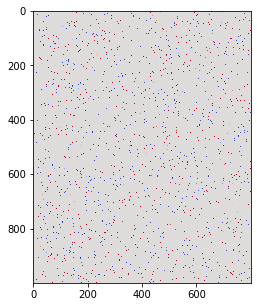

In [37]:
simulation, seed_id, fol_id, seed_choice = Delay_Framework.simulate_activation(
    n_regions = 1000, n_seeds = 200, n_followers = 400, n_timepoints = 800,
    activ_proba = [0, 95], delay = 5, piecewise = True, noise = 0)

#print('seed is {}, fol is {}'.format(seed_id, fol_id))

fig, ax = plt.subplots(figsize = (15, 5))
plt.imshow(simulation, cmap = 'coolwarm', vmin = -2, vmax = 2)
#plt.plot(simulation.T)
#plt.legend(np.arange(5))

In [38]:
bef = time.perf_counter()

del_mean_par, del_std_par = Delay_Framework.delay_measure(simulation, chunksize = 100)

aft = time.perf_counter()
print('Delay Measurement took {}s.'.format(aft - bef))

Working with 1000 regions and 800 timepoints
Using Parallel Implementaion
Measuring delays...
Measure done in 117.70912543899976s.
Delay Measurement took 119.87097345100028s.


In [45]:
bef = time.perf_counter()

del_mean_par, del_std_par = Delay_Framework.delay_measure(simulation,
                                                          progress = False,
                                                          chunksize = 100)

aft = time.perf_counter()
print('Delay Measurement took {}s.'.format(aft - bef))

Working with 1000 regions and 800 timepoints
Using Parallel Implementaion
Measuring delays...
Measure done in 95.82641336699999s.
Delay Measurement took 95.93712625399985s.


In [46]:
bef = time.perf_counter()

del_mean_prog, del_std_prog = Delay_Framework.delay_measure(simulation,
                                                          progress = True,
                                                          chunksize = 100)

aft = time.perf_counter()
print('Delay Measurement took {}s.'.format(aft - bef))

Working with 1000 regions and 800 timepoints
Using Parallel Implementaion
Measuring delays...
Measure done in 101.65461538599993s.
Delay Measurement took 101.91251267999996s.


In [5]:
bef = time.perf_counter()

measure, del_mean_str, del_std_str = Delay_Framework.delay_measure(simulation,
                                                                   parallel = False,
                                                                   return_meas = True)

aft = time.perf_counter()
print('Delay Measurement took {}s.'.format(aft-bef))

Working with 1000 regions and 800 timepoints
Using Straight Forward Implementaion
Measuring delays...
Measure done in 8.478893018999997s.
Computing mean and STD (799 out of 800 time points)...
Computation done in 64.93549279599995s.
–#– Delay Measurement Succeeded –#–
Delay Measurement took 73.43204196500005s.


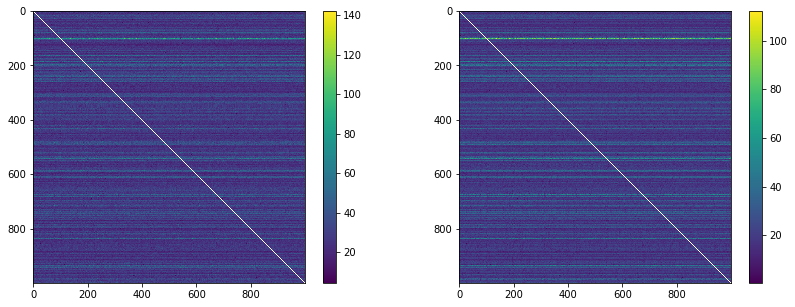

In [6]:
fig, ax = plt.subplots(figsize = (14, 5))

plt.subplot(1, 2, 1)
plt.imshow(del_mean_par)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(del_std_par)
plt.colorbar()

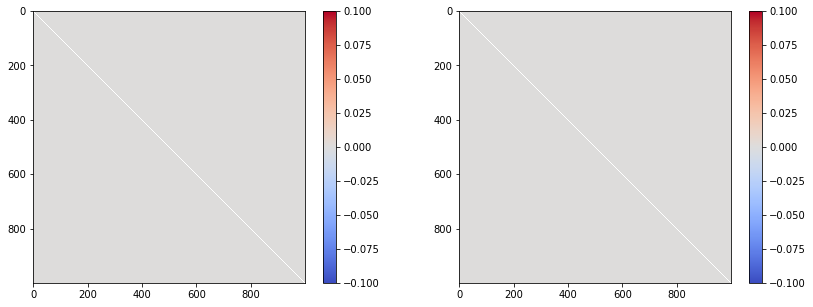

In [49]:
fig, ax = plt.subplots(figsize = (14, 5))

plt.subplot(1, 2, 1)
dif_mean = del_mean_par - del_mean_prog
plt.imshow(dif_mean, cmap = 'coolwarm')
plt.colorbar()

plt.subplot(1, 2, 2)
dif_std = del_std_par - del_std_prog
plt.imshow(dif_std, cmap = 'coolwarm')
plt.colorbar()

In [50]:
print(np.nanmean(dif_mean), np.nanstd(dif_mean))
print(np.nanmean(dif_std), np.nanstd(dif_std))

0.0 0.0
0.0 0.0


## Validation of Delay Framework

In [ ]:
bef = time.perf_counter()
simulation, seed_id, fol_id, seed_choice = Delay_Framework.simulate_activation(
    n_regions = 1000, n_seeds = 200, n_followers = 400, n_timepoints = 800,
    activ_proba = [0, 95], delay = 5, piecewise = True, noise = 0)

aft = time.perf_counter()
print('Simulation took {}s.'.format(aft-bef))

fig, ax = plt.subplots(figsize = (18, 8))
plt.title('Simulated Brain Activity Transitions (innovation signals)', fontsize = 18)

plt.imshow(simulation, cmap = 'coolwarm', vmin = -2, vmax = 2)

plt.xlabel('Time', fontsize = 15)
plt.ylabel('Region', fontsize = 15)

plt.colorbar()

#plt.savefig('FIG_SynthData/WholeSim')

In [ ]:
colmap = 'plasma'

# 38 out of 800
bef = time.perf_counter()

del_std, _ = Delay_Framework.delay_measure(simulation.T, old = False)

aft = time.perf_counter()
print('Delay Measurement took {}s.'.format(aft-bef))

In [ ]:
zscores = stats.zscore(del_std)
zscores_n = zscores/np.nanmin(zscores)

fig, ax = plt.subplots(figsize = (20, 8))

# Plotting 1/Delay Matrix
sub_ax = plt.subplot(1, 2, 1)
plt.title('Computed 1/Delay', fontsize = 15)

plt.xlabel('Responding Region')
plt.ylabel('Activated Region')

plt.imshow(1/del_std, cmap = colmap, vmin = 0, vmax = 1)
plt.colorbar()

# Plotting Expected ROI
sub_ax = plt.subplot(2, 2, 2)
plt.title('Modeled Interactions', fontsize = 15)

highlight = [[i for i in seed_id for j in fol_id], [j for i in seed_id for j in fol_id]]

expected = np.zeros_like(del_std)

for f_id, chosen in zip(fol_id, seed_choice):
    expected[seed_id[seed_choice], fol_id] = 1

plt.imshow(expected[highlight].reshape(len(seed_id), -1), cmap = colmap, vmin = 0, vmax = 1)

plt.xlabel('Responding Region')
plt.ylabel('Activated Region')

sub_ax.set_xticks(np.arange(len(fol_id)))
sub_ax.set_yticks(np.arange(len(seed_id)))
sub_ax.set_yticks(np.arange(len(seed_id)+1)-0.5, minor = True)

sub_ax.set_yticklabels(seed_id)
sub_ax.set_xticklabels(fol_id)
plt.colorbar()

# Plotting Obtained ROI
sub_ax = plt.subplot(2, 2, 4)
plt.title('Z-scores (left tail) of Activity Delay STD', fontsize = 15)

highlight = ([i for i in seed_id for j in fol_id], [j for i in seed_id for j in fol_id])

plt.imshow(zscores[highlight].reshape(len(seed_id), -1),
           cmap = 'plasma_r', vmax = 0)

plt.xlabel('Responding Region', fontsize = 12)
plt.ylabel('Activated Region', fontsize = 12)

sub_ax.set_xticks(np.arange(len(fol_id)))
sub_ax.set_yticks(np.arange(len(seed_id)))
sub_ax.set_yticks(np.arange(len(seed_id)+1)-0.5, minor = True)

sub_ax.set_yticklabels(seed_id)
sub_ax.set_xticklabels(fol_id)

plt.colorbar()

plt.tight_layout()